In [1]:
import numpy as np
import simtk.unit as unit
import matplotlib.pyplot as plt
import openmolecularsystems as oms

# ¿Hemos extraido un buen modelo cinético asociación-disociación?

En la unidad anterior hemos simulado la dinámica de Langevin de una partícula en un doble pozo asimétrico con los siguientes parámetros:

In [2]:
# Sistema
mass = 35.453 * unit.amu

# Potential externo
Eo = 3.0 * unit.kilocalories_per_mole
a = 0.5 * unit.nanometers
b = 0.5 * unit.kilocalories_per_mole
k = 1.0*unit.kilocalories_per_mole/unit.angstrom**2

# Estado termodinámico
temperature=300.0*unit.kelvin

# Parámetros de la simulación
time=100*unit.nanoseconds
saving_timestep=10.0*unit.picoseconds
integration_timestep=0.1*unit.picoseconds
friction=1.0/unit.picoseconds

Podríamos escribir todo el flujo de trabajo para simular este sistema con OpenMM (ver XX), pero dado que la simulación de dinámica molecular y el uso de la librería OpenMM no es el propósito de este material, vamos a recurrir a la librería OpenMolecularSystems confeccionada para facilitar este tipo de demonstraciones y experimentos computacionales:

In [3]:
osystem = oms.DoubleWell(mass=mass, Eo=Eo, a=a, b=b, k=k)

initial_positions = np.zeros([1,3]) * unit.nanometers

reporter = oms.tools.md.langevin_NVT(osystem, time=time, saving_timestep=saving_timestep,
                                     integration_timestep=integration_timestep,
                                     temperature=temperature, friction=friction,
                                     initial_coordinates=initial_positions,
                                     platform_name='CUDA')

1000000it [00:32, 31185.92it/s]        


Vimos como podíamos extraer, de la observación del comportamiento dinámico de la partícula, los parámetros que definen la termodinámica y la cinética de un modelo de dos estados: $P_\textit{on}$, $P_\textit{off}$, $P_{\textit{off} \rightarrow \textit{on}}$ y $P_{\textit{on} \rightarrow \textit{off}}$. Por que conocemos que los estados "on" y "off" se definen como el espacio conformacional que se encuentra cumpliendo que $x\leq x_{b}$ y $x> x_{b}$ correspondientemente, donde $x_{b}$ es la coordenada del máximo de la barrera en el eje $X$:

In [4]:
traj_x = reporter['coordinates'][:,0,0]
xb = osystem.get_coordinates_maximum()[0][0]

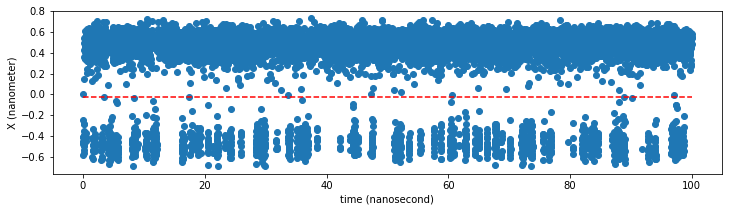

In [5]:
plt.figure(figsize=(12,3))
plt.scatter(reporter['time'].in_units_of(unit.nanoseconds), traj_x)
plt.hlines(xb._value,0,100, linestyle='--', color='red')
plt.ylabel('X ({})'.format(reporter['coordinates'].unit))
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.show()

In [6]:
m_on = np.sum(traj_x<=xb)
m_off = traj_x.shape[0] - m_on

Pe_on = m_on/(m_on+m_off)
Pe_off = 1.0-Pe_on

print('Pe_on = {}'.format(Pe_on))
print('Pe_off = {}'.format(Pe_off))

Pe_on = 0.1548845115488451
Pe_off = 0.8451154884511549


In [7]:
m_off_to_on = 0
m_on_to_off = 0
traj_is_on = (traj_x<=xb)

for frame_index in range(traj_is_on.shape[0]-1):
    now = traj_is_on[frame_index]
    after = traj_is_on[frame_index+1]
    if now==True and after==False:
        m_on_to_off+=1
    elif now==False and after==True:
        m_off_to_on+=1

P_off_to_on = m_off_to_on/m_off
P_on_to_off = m_on_to_off/m_on

print('P_off_to_on = {}'.format(P_on_to_off))
print('P_on_to_off = {}'.format(P_off_to_on))

P_off_to_on = 0.05874757908327954
P_on_to_off = 0.010766682442025556


Y por lo tanto las constantes cinéticas son:

In [8]:
K_off_to_on = P_off_to_on/saving_timestep
K_on_to_off = P_on_to_off/saving_timestep

print('K_off_to_on = {}'.format(K_on_to_off))
print('K_on_to_off = {}'.format(K_off_to_on))

K_off_to_on = 0.005874757908327954 /ps
K_on_to_off = 0.0010766682442025558 /ps


Tenemos entonces un modelo cinético de dos estados construido con las probabilidades de transición:

\begin{cases}
\begin{align}
\frac{d P_\textit{on}(t)}{dt} = -K_{\textit{on} \rightarrow \textit{off}} P_\textit{on}(t) + K_{\textit{off} \rightarrow \textit{on}} P_\textit{off}(t) \\ \\
\frac{d P_\textit{on}(t)}{dt} = K_{\textit{on} \rightarrow \textit{off}} P_\textit{on}(t) - K_{\textit{off} \rightarrow \textit{on}} P_\textit{off}(t)
\end{align}
\end{cases}

Puede probarse que las probabilidades obtenidas anteriormente, $P_\textit{on}$ y $P_\textit{off}$, son soluciones estacionarias del modelo cinético. Y en este caso, como tenemos únicamente dos estados, el balance detallado se cumple por construcción.

Veamos cómo se comporta el modelo. Pero antes, hagamos una puntualización con respecto a la notación, de ahora en adelante y para no confundir las probabilidades estacionarias con las variables del modelo cinético $P_\textit{on}(t)$, denotaremos como $P^{e}_\textit{on}$ a lo que antes llamabamos $P_\textit{on}$.

Integremos la dinámica de nuestro modelo cinético cuando inicialmente ponemos toda la población, toda la probabilidad, de nuestro sistema en el estado 'off' y veamos como el sistema relaja al equilibrio.

In [9]:
P_on = 0.0
P_off = 1.0

integration_step = 1.0*unit.picoseconds
total_time = 3.0*unit.nanoseconds
n_steps = int(total_time/integration_step)

traj_Ps = np.zeros([n_steps,2])
time_Ps = np.zeros([n_steps])*unit.picoseconds
traj_Ps[0,0] = P_on
traj_Ps[0,1] = P_off

for step_index in range(1, n_steps):
    dP_on = (-K_on_to_off*P_on+K_off_to_on*P_off)*integration_step
    dP_off = (K_on_to_off*P_on-K_off_to_on*P_off)*integration_step
    P_on += dP_on
    P_off += dP_off
    traj_Ps[step_index,0]=P_on
    traj_Ps[step_index,1]=P_off
    time_Ps[step_index]=step_index*integration_step

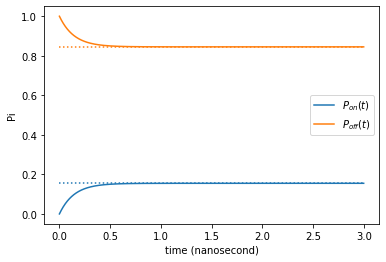

In [10]:
plt.plot(time_Ps.in_units_of(unit.nanoseconds), traj_Ps[:,0], label='$P_{on}(t)$')
plt.plot(time_Ps.in_units_of(unit.nanoseconds), traj_Ps[:,1], label='$P_{off}(t)$')
plt.ylabel('Pi')
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.legend()
plt.hlines(Pe_on, 0.0, 3.0, ls=':', color='#1f77b4')
plt.hlines(Pe_off, 0.0, 3.0, ls=':', color='#ff7f0e')
plt.show()

En el gráfico hemos representado en linea punteada los valores de las probabilidades estacionarias del modelo. Vemos que pasado menos de un nanosegundo el sistema "alcanza el equilibrio". La distribución de probabilidad casi ya es estacionaria.

¿Pero es este un buen modelo? ¿Obtuvimos unos buenos parámetros? Este pregunta nos la tenemos que hacer siempre. ¿Qué predicción podemos comparar resultado del modelo con el experimento? Antes de contestar esta última pregunta, seguramente estás pensando en algo mas sencillo. ¿Estoy seguro de que los valores con los que construyo el modelo cinético son fiables?¿Cúan fiables?

## ¿La distribución de probabilidad que observo ha convergido?

Lo primero que tengo que preguntarme es, ¿son suficientes 100ns para decir algo mínimamente confiable sobre la termodinámica? Hagamos algo, vamos a calcular la probabilidad estacionaria $P^{e}_\textit{on}$ (la $P^{e}_\textit{off}$ no es nada más que $1-P^{e}_\textit{off}$) para cada tiempo $t'$ con el segmento de trayectoria $0\leq t \leq t'$:

In [11]:
M = traj_x.shape[0]
traj_is_on = (traj_x<=xb)

Pe_on_in_time = np.zeros([M])

for frame_index in range(M):
    m_on_aux = np.sum(traj_is_on[:frame_index])
    Pe_on_in_time[frame_index] = m_on_aux/(frame_index+1)

Pe_off_in_time = 1.0 - Pe_on_in_time

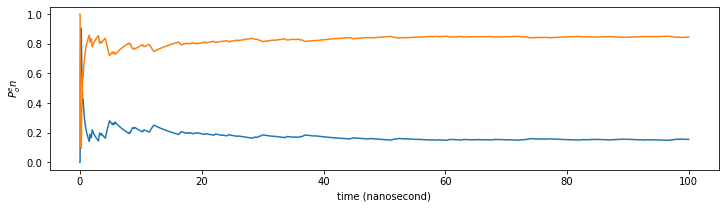

In [12]:
plt.figure(figsize=(12,3))
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), Pe_on_in_time)
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), Pe_off_in_time)
plt.ylabel('$P^e_on$'.format(reporter['coordinates'].unit))
plt.xlabel('time ({})'.format(unit.nanoseconds))
#plt.xlim([50.0, 100.0])
#plt.ylim(0.15, 0.25)
plt.show()

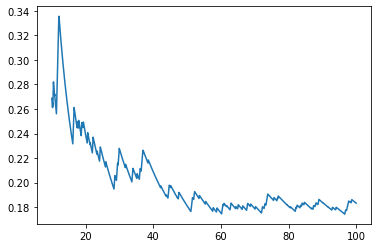

In [13]:
plt.plot(reporter['time'][1000:].in_units_of(unit.nanoseconds), Pe_on_in_time[1000:]/Pe_off_in_time[1000:])
plt.show()

¿Que margen de error le otorgas a tu valor final de $K_{D}$?

## ¿Tengo suficiente estadística para decir algo de la cinética?

Hagamos lo mismo con la probabilidad de transición $P_{\textit{on}\rightarrow \textit{off}}$:

In [14]:
M = traj_x.shape[0]
traj_is_on = (traj_x<=xb)

P_on_to_off_in_time = np.zeros([M])

num_hops = 0
num_ons = 0

for frame_index in range(M-1):
    now = traj_is_on[frame_index]
    after = traj_is_on[frame_index+1]
    if now==True:
        num_ons +=1
        if after==False:
            num_hops+=1
    try:
        P_on_to_off_in_time[frame_index+1] = num_hops/num_ons
    except:
        P_on_to_off_in_time[frame_index+1] = np.nan

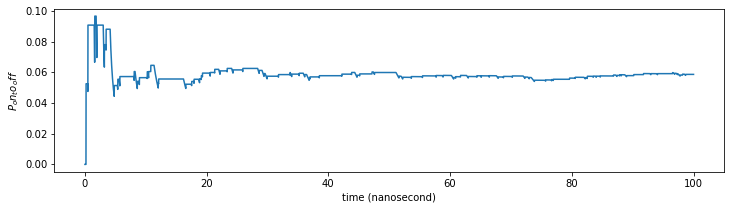

In [15]:
plt.figure(figsize=(12,3))
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), P_on_to_off_in_time)
plt.ylabel('$P_on_to_off$'.format(reporter['coordinates'].unit))
plt.xlabel('time ({})'.format(unit.nanoseconds))
#plt.xlim([50.0, 100.0])
#plt.ylim(0.05, 0.07)
plt.show()

Preguntas:

- El modelo cinético equilibra en menos de un segundo, pero nuestros observables no convergen en 50 nanosegundos. ¿Cómo casa esto?
- ¿Es lo mismo que el sistema haya equilibrado que que nuestra estadística sea suficiente para describir el equilibrio?
- ¿Crees que para tener un mejor valor de tus observables tengas que prescindir del segmento inicial de la trayectoria?¿De cuanto tiempo prescindirías?